In [51]:
import numpy as np
import matplotlib.pyplot as plt

Read in an image of a domino with plt.imread()

In [52]:
im_c = plt.imread("test set 1/bottom_a49.jpg")

Show that it has successfully read.

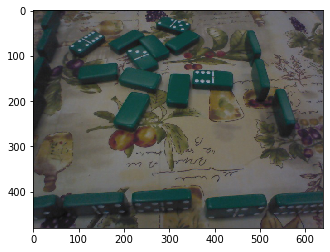

In [53]:
plt.imshow(im_c)
plt.show()

Convert the image to grayscale and create histogram.

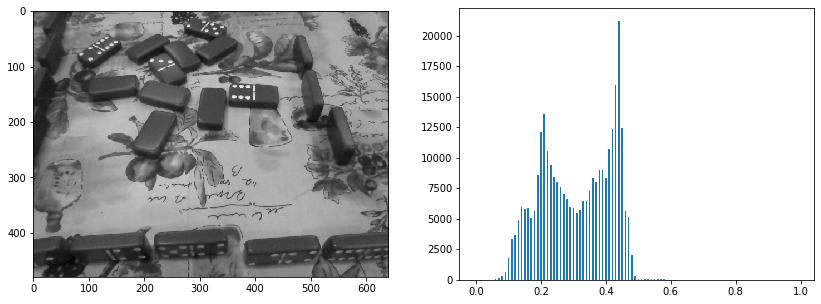

In [54]:
from skimage import color

im_g = color.rgb2gray(im_c)

hist, bins = np.histogram(im_g,bins=np.linspace(0,1,101))

fig, ax = plt.subplots(ncols=2,figsize=(14,5))

ax[0].imshow(im_g, cmap='gray')
ax[1].bar(bins[:-1],hist,width=0.005)
plt.show()

This histogram shows me that there are barely any high intensity pixels. I might want to fix that with equalize_hist.

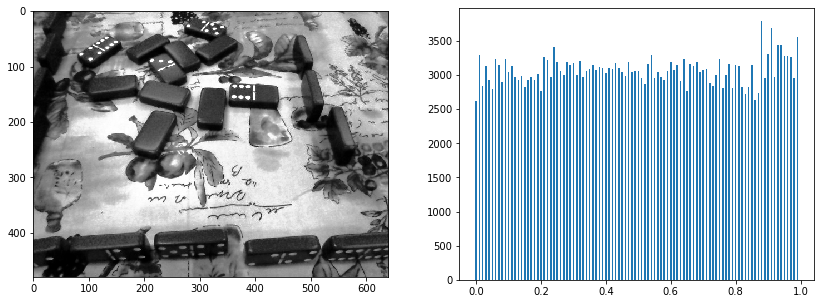

In [55]:
from skimage import exposure

im_eq = exposure.equalize_hist(im_g)

hist, bins = np.histogram(im_eq,bins=np.linspace(0,1,101))

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_eq, cmap='gray')
ax[1].bar(bins[:-1],hist,width=0.005)
plt.show()

I'll test if this image is easier to detect after testing with im_g.

Test background subtraction from L4.

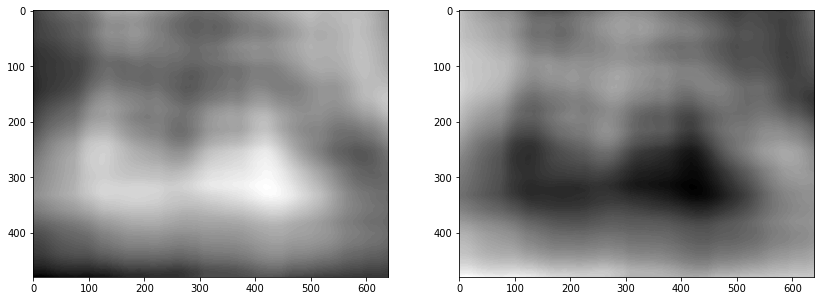

In [56]:
import skimage.filters as flt
from skimage.morphology import square

def custom_uint(im):
    
    imin = np.min(im)
    imax = np.max(im)
    full = imax - imin
    new = np.round(255*(im - imin)/full, 0)
    return new.astype(int)

im_bg = flt.rank.mean(im_g,square(150))
im_sub = custom_uint(im_g-1*im_bg)

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_bg, cmap='gray')
ax[1].imshow(im_sub, cmap='gray')
plt.show()

This didn't help at all...

Try edge detection from the feature module.

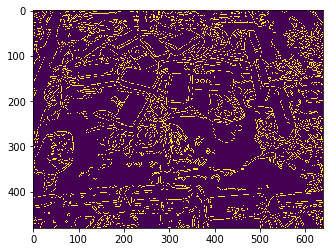

In [57]:
from skimage.feature import canny

edges = canny(im_eq,sigma=1.0)
plt.imshow(edges)
plt.show()

This doesn't seem to be detecting the edges of dots. Probably not usefull right now.

Try a threshold filter.

In [58]:
thresh = flt.threshold_otsu(im_eq)
thresh

0.5019596099853516

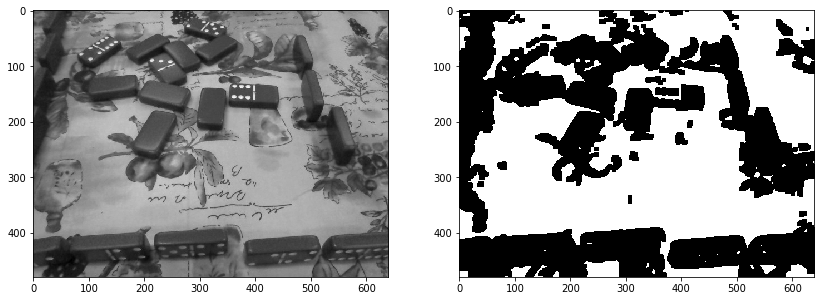

In [59]:
from skimage.morphology import closing #I think closing fills in holes.

bw = closing(im_eq>thresh, square(7))
bw
fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_g, cmap='gray')
ax[1].imshow(bw, cmap='gray')
plt.show()

Might be able to detect dominoes with this, but only because the dominoes are different enough from the background.

I'm thinking the dots are too small compared to the larger objects to be detected with this threshold.

Let's try template matching.
Here's a dot I pulled from some image.

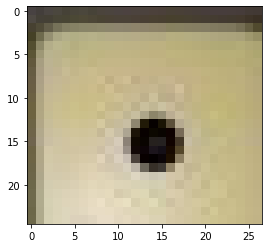

In [60]:
dot = plt.imread("template matching/singledot.jpg")
plt.imshow(dot)
plt.show()

In [61]:
dot.shape

(25, 27, 3)

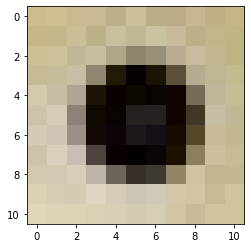

In [62]:
just_the_dot = dot[10:21,9:20]
plt.imshow(just_the_dot)
plt.show()

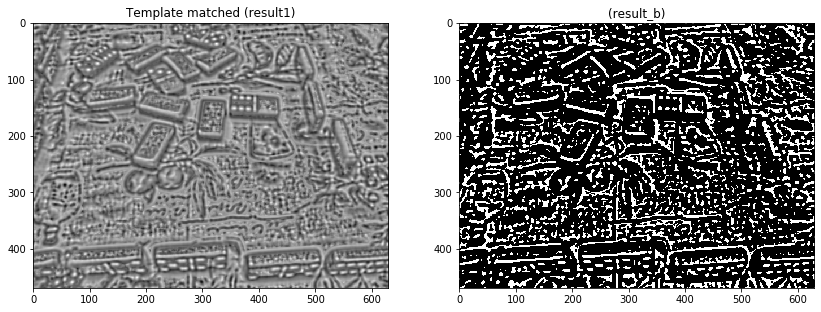

In [63]:
from skimage.feature import match_template

dot = color.rgb2gray(just_the_dot) # just_the_dot is too long so I'll overwrite dot

result1 = 1-match_template(im_g,dot)
result_b = result1> flt.threshold_otsu(result1)*1.2

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(result1, cmap='gray')
ax[0].set_title("Template matched (result1)")
ax[1].imshow(result_b, cmap='gray')
ax[1].set_title("(result_b)")
plt.show()

The left template matched image might be good because the dot's look brighter than the rest of the image. I might try blob detection on this later. The right image is probably useless because of how messy it is.

In [64]:
im_g.shape

(480, 640)

In [65]:
result1.shape

(470, 630)

The template matched image is smaller than the origional image because it does some weird

Let's try a local threshold and see if we can get rid of some mess.

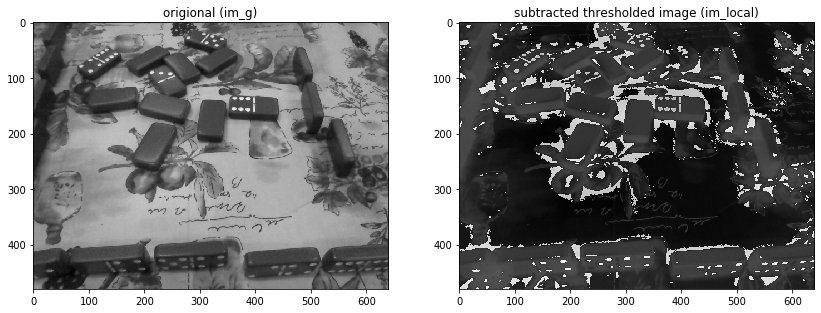

In [128]:
thresh_l = flt.threshold_local(im_g,61,offset=-0.06) #Can tweek offset to get more or less
local = im_g>thresh_l
im_local = local-im_g

fig, ax = plt.subplots(ncols=2,figsize=(14,5))
ax[0].imshow(im_g, cmap='gray')
ax[0].set_title("origional (im_g)")
ax[1].imshow(im_local, cmap='gray')
ax[1].set_title("subtracted thresholded image (im_local)")
plt.show()

This looks promissing. Let's do more template matching.

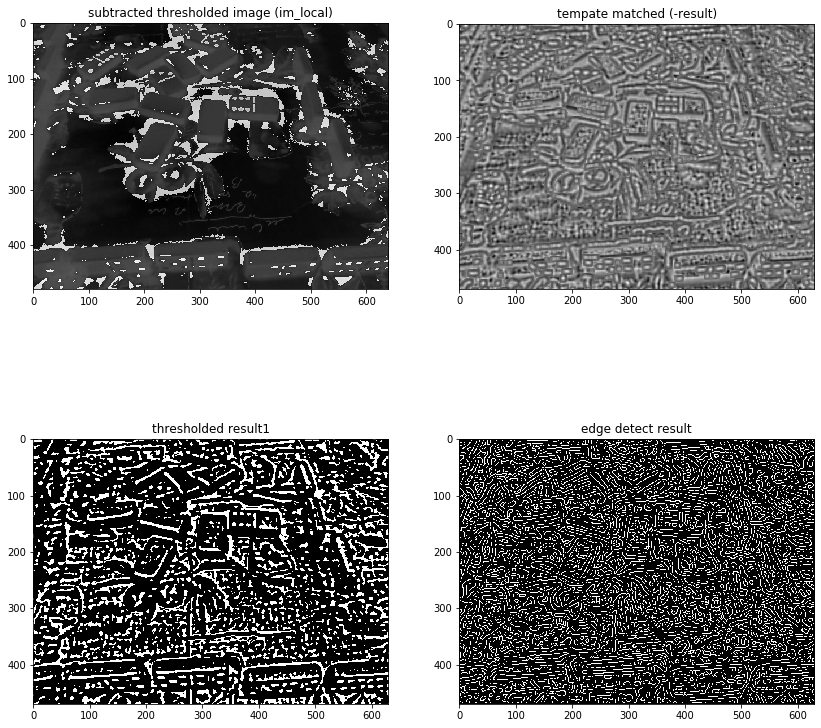

In [138]:
result = match_template(im_local,dot)
thresh = flt.threshold_otsu(result1)

result1_thresh = ((result1)>(thresh*1.2))
resultedge = canny(result,sigma=5) #what does sigma even do?

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(14,14))
ax[0,0].imshow(im_local, cmap='gray')
ax[0,0].set_title("subtracted thresholded image (im_local)")
ax[0,1].imshow(-1*result, cmap='gray')
ax[0,1].set_title("tempate matched (-result)")

ax[1,0].imshow(result1_thresh, cmap='gray')
ax[1,0].set_title("thresholded result1")
ax[1,1].imshow(result_edge, cmap='gray')
ax[1,1].set_title("edge detect result")
plt.show()

Harini suggests using the measure module. I'll use find_contours

In [140]:
from skimage.measure import find_contours
from skimage.transform import resize

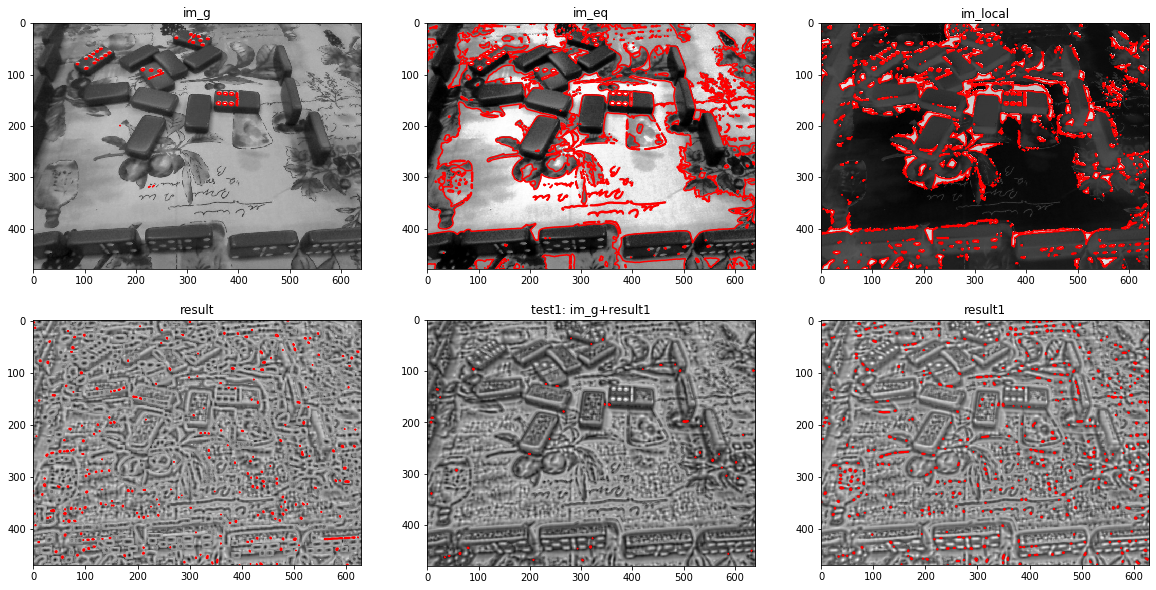

In [143]:

fig,ax = plt.subplots(nrows=2, ncols=3,figsize=(20,10))

test1 = im_g+resize(result1,(im_g.shape[0],im_g.shape[1])) #because template matching changes the size

ax[0,0].imshow(im_g,cmap='gray')
ax[0,0].set_title("im_g")
ax[0,1].imshow(im_eq,cmap='gray')
ax[0,1].set_title("im_eq")
ax[0,2].imshow(im_local,cmap='gray')
ax[0,2].set_title("im_local")
ax[1,0].imshow(result,cmap='gray')
ax[1,0].set_title("result")
ax[1,1].imshow(test1,cmap='gray')
ax[1,1].set_title("test1: im_g+result1")
ax[1,2].imshow(result1,cmap='gray')
ax[1,2].set_title("result1")

contours = [find_contours(im_g,0.5),find_contours(im_eq,0.5),find_contours(im_local,0.45),
            find_contours(result,0.5),find_contours(test1,0.6),find_contours(result1,0.5)]

#applying contours to all images
for col,im in enumerate(contours):
    if col<3:
        row=0
    else:
        row=1
    for n, contour in enumerate(im):
        if col>2:
            col=abs(3-col)
        else:
            pass
        ax[row,col].plot(contour[:,1],contour[:,0],color='r')

The origional image was the most accurate... I guess the local thresholded one also got all the dots, and most of the background. 

Maybe I can use that to increase the brightness at the countours around the dots and then do template matching.

In [165]:
contours = find_contours(im_local,0.45)

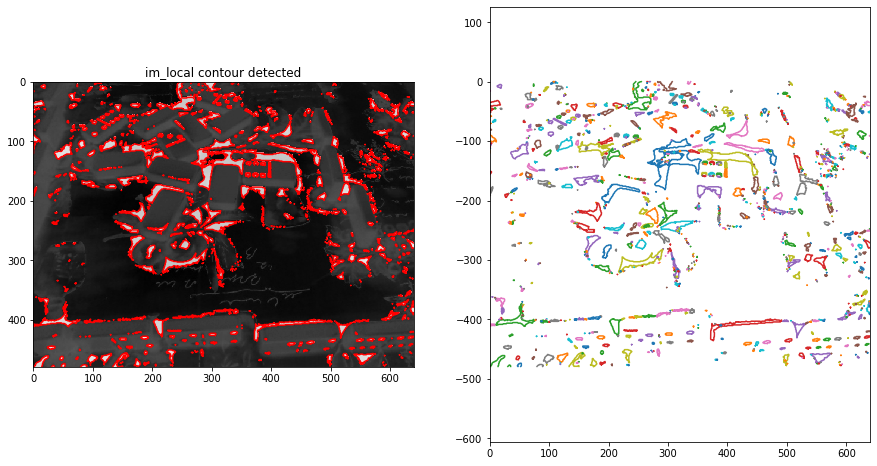

In [174]:
fig,ax = plt.subplots(ncols=2,figsize=(15,8))

ax[0].imshow(im_local,cmap='gray')
ax[0].set_title("im_local contour detected")
    
for n, contour in enumerate(contours):
    ax[0].plot(contour[:,1],contour[:,0],color='r')
    ax[1].plot(contour[:,1],-contour[:,0])
ax[1].axis("equal")
ax[1].set_xlim(0,im_local.shape[1])
ax[1].set_ylim(-im_local.shape[0],0) #why doesn't this work?

plt.show()

Now how do I convert this into a single array that I can add to the origional image??

Let's test some peak detection.

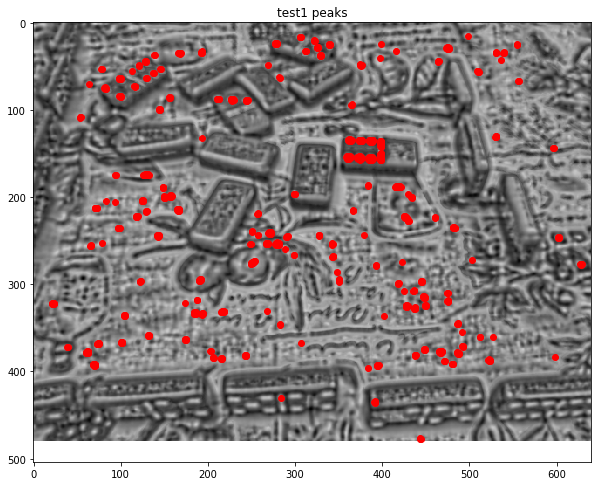

In [176]:
thresh = flt.threshold_otsu(test1)
locs = np.where(test1>thresh*1.5)
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(test1,cmap='gray')
ax.scatter(locs[1],locs[0],color='r')
ax.set_title("test1 peaks")
plt.show()

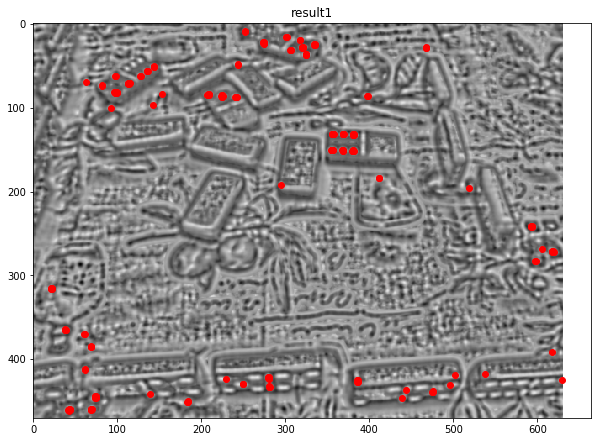

In [178]:
thresh = flt.threshold_otsu(result1)
locs = np.where(result1>thresh*1.7)
fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(result1,cmap='gray')
ax.scatter(locs[1],locs[0],color='r')
ax.set_title("result1")
plt.show()

Let's try blob detection.

First determinate of hessian since that looks like it works best on skimages website.

In [180]:
from skimage.feature import blob_doh

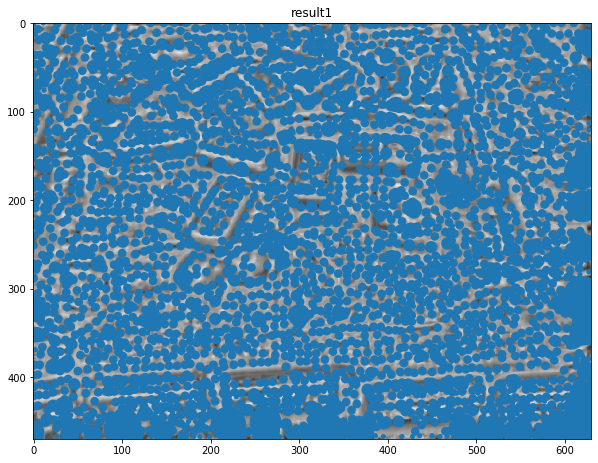

In [227]:
thresh=flt.threshold_otsu(result1)
blobs = blob_doh(result1,min_sigma=3,max_sigma=20,threshold=0.008,overlap=1)

fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(result1,cmap='gray')

for x, y, r in blobs:
    circle = plt.Circle((y,x),r)
    ax.add_patch(circle)
    
ax.set_title("result1")
plt.show()

Well that's a mess.

Maybe I can run template matching again to get brighter dots?

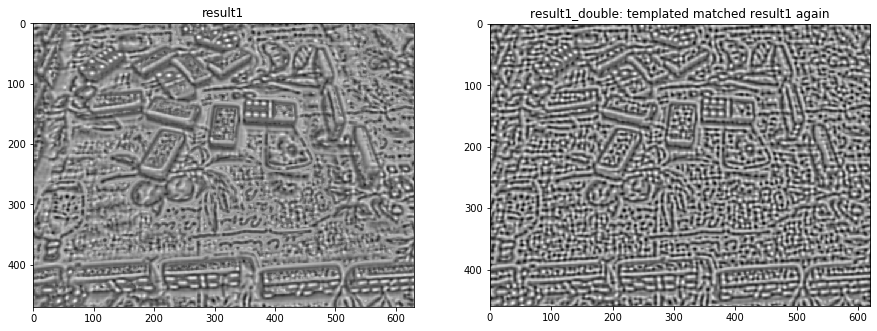

In [229]:
result1_double = 1-match_template(result1,dot)

fig,ax = plt.subplots(ncols=2, figsize=(15,8))

ax[0].imshow(result1,cmap='gray')
ax[0].set_title("result1")
ax[1].imshow(result1_double,cmap='gray')
ax[1].set_title("result1_double: templated matched result1 again")
plt.show()

Maybe I can denoise first?